In [7]:
import pandas as pd
from pandas_summary import DataFrameSummary
pd.set_option('display.max_rows', 10)
import ast
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set(style="whitegrid",context = 'poster', rc={'figure.figsize':(15,10), 
                                                  'xtick.labelsize': 16,
                                                 'ytick.labelsize': 16})

# Load data

In [3]:
ser = pd.read_json('data/unlabelled_recipies.json')['ingredients'].sort_index()
print(len(ser))

39774


# EDA

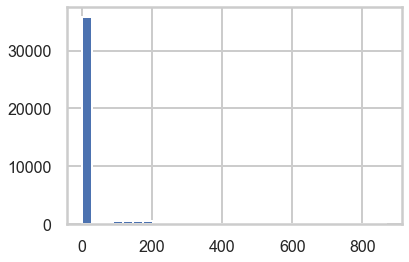

In [8]:
#something strange is happening, some entries are strings, not lists
ser.apply(len).hist(bins =30)

In [9]:
len(ser)

39774

checking types <class 'list'>    39774
Name: ingredients, dtype: int64


Text(0, 0.5, 'Counts')

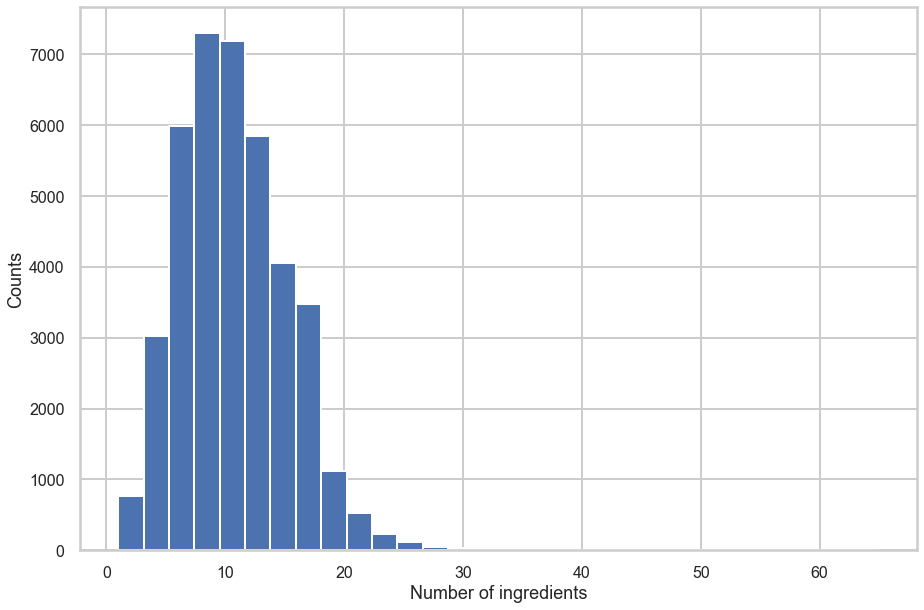

In [10]:
def convert_type(entry):
    if isinstance(entry, list):
        return entry
    if isinstance(entry, str):
        return ast.literal_eval(entry)
    
fig, ax = plt.subplots(figsize=(15, 10))
    
ser = ser.apply(convert_type)
print('checking types', ser.apply(type).value_counts())

ser.apply(len).hist(bins =30)

ax.set_xlabel('Number of ingredients', fontsize = 18)
ax.set_ylabel('Counts', fontsize = 18)

In [11]:
ser_ings = ser.apply(pd.Series).stack().dropna()#.value_counts()

In [12]:
ser_corpus = ser.apply(lambda li: ' '.join(ing.strip().replace(' ', '_') for ing in li))

In [13]:
ser[ser_corpus.apply(lambda x: '(____oz.)_tomato_sauce' in x)]

4554     [beef, fresh basil leaves, ground veal, italia...
12434    [parmesan cheese, sauce, olive oil, fat skimme...
12888    [garlic, vermicelli, olive oil, (10 oz.) froze...
17074    [dried oregano, dry lasagna, fat skimmed chick...
17089    [(    oz.) tomato sauce, vinegar, firmly packe...
                               ...                        
23291    [orange zest, duck drumsticks, pappardelle pas...
24001    [penne pasta, (    oz.) tomato sauce, pepper, ...
24305    [boiling onions, garlic, dried oregano, olive ...
25039    [cayenne pepper, green bell pepper, (    oz.) ...
35584    [salt, lean ground beef, chopped celery, (    ...
Name: ingredients, Length: 11, dtype: object

# TFiDF time 

In [23]:
ser_corpus[ser_corpus.apply(lambda x: '_dressing_' in x)].iloc[10]

'lime_juice black_beans frozen_whole_kernel_corn tomatoes ground_cumin chopped_cilantro jalapeno_chilies purple_onion salad_dressing_mix tortilla_chips'

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = ser_corpus
vectorizer = TfidfVectorizer(token_pattern= '\S+', min_df =5, use_idf = True ,norm = 'l2') #split on spaces only # max_df = 0.01
X = vectorizer.fit_transform(corpus)
#print(vectorizer.get_feature_names())

print(X.shape)

df_vect = pd.DataFrame(X.todense())
df_vect.columns = vectorizer.get_feature_names()

(39774, 3336)


In [27]:
# ser_idf = pd.Series(index=vectorizer.get_feature_names(),data= vectorizer.idf_)
# (1/ser_idf.sort_values()).to_frame()

# 2D projection

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [48]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, n_iter=10, random_state=666)
X_embedded = svd.fit_transform(X)  

#print(svd.explained_variance_ratio_)  

print(svd.explained_variance_ratio_.sum())  

#print(svd.singular_values_)  

0.1899875750796403


# Clustering

In [55]:
from sklearn.cluster import MiniBatchKMeans

10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48


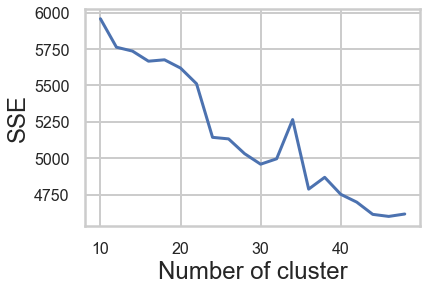

In [51]:
sse = {}
for k in range(10, 50, 2):
    print(k)
    kmeans = MiniBatchKMeans(n_clusters=k, max_iter=1000).fit(X_embedded)
    #kmeans = MiniBatchKMeans(n_clusters=k, max_iter=1000).fit(df_vect)
    df_vect["clusters"] = kmeans.labels_
    # print(data["clusters"])
    # Inertia: Sum of distances of samples to their closest cluster center
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [56]:
clusters = MiniBatchKMeans(n_clusters=30, random_state=666).fit_predict(X_embedded)

Text(0, 0.5, 'Counts')

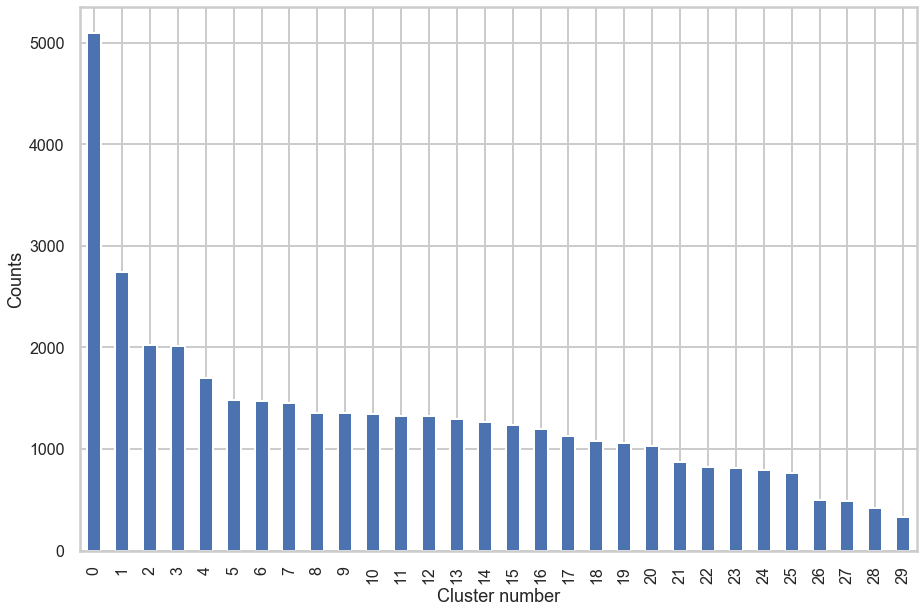

In [58]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 10))

p = pd.Series(clusters).value_counts().reset_index(drop=True).plot.bar()

ax.set_xlabel('Cluster number', fontsize = 18)
ax.set_ylabel('Counts', fontsize = 18)

In [89]:
import numpy as np
from sklearn.manifold import TSNE

N = 500
subs_X = pd.DataFrame(X_embedded).sample(N)
subs_idxs = subs_X.index

X_embedded_TSNE = TSNE(n_components=2).fit_transform(pd.DataFrame(X_embedded).sample(500))
X_embedded_TSNE.shape

(500, 2)

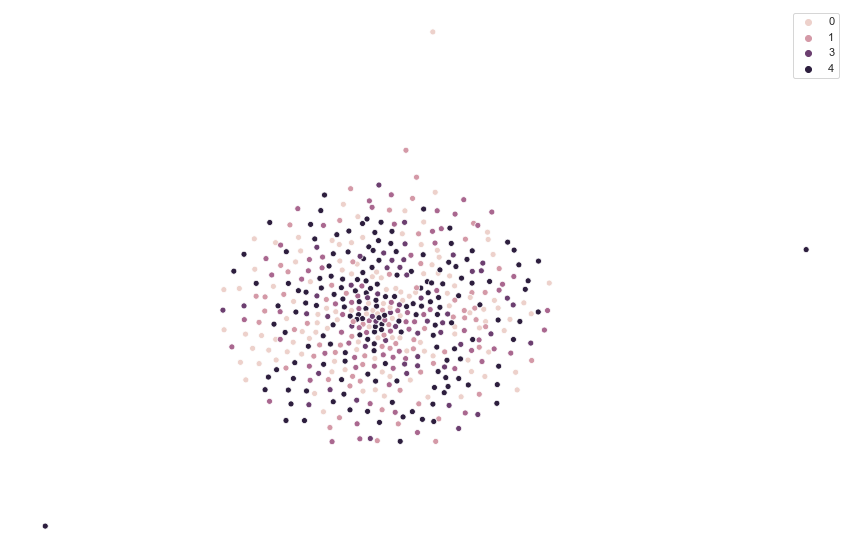

In [90]:
import seaborn as sns

sns.set(rc={'figure.figsize':(15,10)}) 
sns.set_style("whitegrid", {'axes.grid' : False}) 

#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x=X_embedded_TSNE[:, 0],
                y=X_embedded_TSNE[:, 1],
#                 hue=[cat_skill_map.get(skill, 'other')
#                      for skill in skill2vec.wv.vocab],
                hue = clusters[subs_idxs],
                #palette=sns.color_palette("hls", N)
                #palette=sns.color_palette("colorblind", 12)
                #cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True, n_colors=12)
               )
_ = ax.axis('off') 